# Investigating renewable energy consumption in the EU

## Alessandro Cortese
### M.Sc. in Data Science student at UniTN


The purpose of this analysis is to investigate the consumption of different types of renewable energies in the European Union.
Data have been downloaded from [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_rw/default/table?lang=en) in a .tsv format.

N.B. Although I am aware of the fact that there are several APIs and libraries to download Eurostat data in a convenient way, I wanted to process data without using them, just to show a general way of dealing with such kinds of datasets.

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Data Cleaning and Preparation


In [2]:
df_energy = pd.read_csv("nrg_cb_rw.tsv", sep = "\t")

print(f"The dimensions of the dataset are: {df_energy.shape}")
df_energy.head()

The dimensions of the dataset are: (34830, 33)


,"nrg_bal,siec,unit,geo\time",2021,2020,2019,2018,2017,2016,2015,2014,2013,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,"DL,R5110-5150_W6000RI,TJ,AL",:,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,"DL,R5110-5150_W6000RI,TJ,AT",:,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,"DL,R5110-5150_W6000RI,TJ,BA",:,0.000,0.000,0.000,0.000,0.000,0.000,0.000,:,...,:,:,:,:,:,:,:,:,:,:
3,"DL,R5110-5150_W6000RI,TJ,BE",:,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,"DL,R5110-5150_W6000RI,TJ,BG",:,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,110.000,40.000,22.000,12.000,13.000,2.000,0.000,0.000,0.000


We load the dataset as a pandas dataframe, but we already notice that the first column actually contains four variables. This is because in our .tsv file we have a mixture of tabs and commas. One solution could be to read the file, replace the commas with tabs, write this to a new file and then read again from it. We are also getting rid of the whitespaces, since otherwise they will be read as part of the columns or the cells (_i.e._ the columns are going to be named "2014 ", "2015 ", etc., with a whitespace at the end), and this could become annoying later on.

In [3]:
with open("nrg_cb_rw.tsv") as file:
    lines = file.read().replace(',', '\t').replace(" ", "") # substituting commas with tabs

with open("nrg_cb_new.tsv", "w") as file2: 
    file2.write(lines) # writing to a new file

In [4]:
df_energy = pd.read_csv("nrg_cb_new.tsv", sep = "\t")

df_energy.head()

,nrg_bal,siec,unit,geo\time,2021,2020,2019,2018,2017,2016,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,DL,R5110-5150_W6000RI,TJ,AL,:,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,DL,R5110-5150_W6000RI,TJ,AT,:,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,DL,R5110-5150_W6000RI,TJ,BA,:,0.000,0.000,0.000,0.000,0.000,...,:,:,:,:,:,:,:,:,:,:
3,DL,R5110-5150_W6000RI,TJ,BE,:,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,DL,R5110-5150_W6000RI,TJ,BG,:,0.000,0.000,0.000,0.000,0.000,...,0.000,110.000,40.000,22.000,12.000,13.000,2.000,0.000,0.000,0.000


Now it is way better. Let's also notice the warning that pandas gives us about mixed types in the columns from 6 to 11 (which I have hidden in my notebook, but will result when running the code). This is because NA's are represented by colons. Let's fix this by specifying the parameter **na_values**.

In [5]:
df_energy = pd.read_csv("nrg_cb_new.tsv", sep = "\t", na_values = ":")

df_energy.head()

,nrg_bal,siec,unit,geo\time,2021,2020,2019,2018,2017,2016,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,DL,R5110-5150_W6000RI,TJ,AL,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DL,R5110-5150_W6000RI,TJ,AT,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DL,R5110-5150_W6000RI,TJ,BA,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DL,R5110-5150_W6000RI,TJ,BE,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DL,R5110-5150_W6000RI,TJ,BG,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,110.0,40.0,22.0,12.0,13.0,2.0,0.0,0.0,0.0


Now, again Pandas gives us a warning, saying that the fifth column ("2021") has mixed types. This is because those values are predicted, and thus signalled with a "p" right after the number itself, thus creating confusion. Since these values are not official ones, however, we can just discard this column from our analysis.


In [6]:
df_energy = df_energy.drop("2021", axis = 1)


Again, another thing that we notice is the rather obscure codes that we have under the "siec" column. SIEC actually stands for Standard International Energy Product Classification. [Here](https://dd.eionet.europa.eu/vocabulary/eurostat/siec/view?page=10#vocabularyConceptResults) we can take a look what those code stand for, and replace them into our dataframe for more clarity. Also, while we are at it, we can substitute the unexplanatory column name "geo\time" with "country_code".

In [7]:
df_energy["siec"].unique() # find the different energy sources in the dataframe

array(['R5110-5150_W6000RI', 'R5160', 'R5210E', 'R5210P', 'R5220P',
       'R5230P', 'R5290', 'R5300', 'RA200', 'RA410', 'W6100', 'W6210',
       'W6220', 'RA600', 'R5110', 'R5111', 'R5120', 'R5130', 'R5140',
       'R5150', 'R5310', 'R5311', 'R5312', 'R5319', 'R5320', 'W6000RI'],
      dtype=object)

In [8]:
energy_terms = {
    'R5110-5150_W6000RI': "Primary solid biofuels",
    'R5160': "Charcoal",
    'R5210E': "Bioethanol",
    'R5210P': "Pure biogasoline",
    'R5220P': "Pure biodiesels",
    'R5230P': "Pure bio jet kerosene", 
    'R5290': "Other liquid biofuels", 
    'R5300': "Biogases", 
    'RA200': "Geothermal", 
    'RA410': "Solar thermal", 
    'W6100': "Industrial waste (non-renewable)", 
    'W6210': "Renewable municipal waste",
    'W6220': "Non-renewable municipal waste", 
    'RA600': "Ambient heat (heat pumps)", 
    'R5110': "Fuelwood, wood residues and byproducts", 
    'R5111': "Wood pellets", 
    'R5120': "Bagasse", 
    'R5130': "Animal waste", 
    'R5140': "Black liquor",
    'R5150': "Other vegetal material and residues", 
    'R5310': "Biogases from anaerobic fermentation", 
    'R5311': "Landfill gas", 
    'R5312': "Sewage sludge gas", 
    'R5319': "Other biogases from anaerobic fermentation", 
    'R5320': "Biogases from thermal processes", 
    'W6000RI': "Renewable fraction of industrial waste"
}

df_energy.replace(energy_terms, inplace = True) # substituting the codes with the full names of the energy sources

df_energy.rename({'geo\\time': 'country_code'}, axis=1, inplace=True) # double slash otherwise \t gets recognized as tab!

df_energy

,nrg_bal,siec,unit,country_code,2020,2019,2018,2017,2016,2015,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,DL,Primary solid biofuels,TJ,AL,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DL,Primary solid biofuels,TJ,AT,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DL,Primary solid biofuels,TJ,BA,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DL,Primary solid biofuels,TJ,BE,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DL,Primary solid biofuels,TJ,BG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,110.0,40.0,22.0,12.0,13.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34825,TI_PF_E,Non-renewable municipal waste,TJ,SK,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34826,TI_PF_E,Non-renewable municipal waste,TJ,TR,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34827,TI_PF_E,Non-renewable municipal waste,TJ,UA,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34828,TI_PF_E,Non-renewable municipal waste,TJ,UK,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, let's explore the dataset. What is the nrg_bal column? It turns out that, reading the [documentation](https://ec.europa.eu/eurostat/documents/38154/4956218/ENERGY-BALANCE-GUIDE-DRAFT-31JANUARY2019.pdf/cf121393-919f-4b84-9059-cdf0f69ec045) that comes with the dataset, that this column represents the various flows present in Eurostat's energy balances. For example, "DL" stands for "Distribution losses", "EX" stands for "Exports", etc. We are only going to select "FC_E", which stands for "Final consumption - Energy use". This means that we are excluding the non-energy use (*e.g.* heating)!

In [9]:
df_energy.nrg_bal.unique()

array(['DL', 'EXP', 'FC', 'FC_E', 'FC_IND_CON_E', 'FC_IND_CPC_E',
       'FC_IND_E', 'FC_IND_FBT_E', 'FC_IND_IS_E', 'FC_IND_MAC_E',
       'FC_IND_MQ_E', 'FC_IND_NFM_E', 'FC_IND_NMM_E', 'FC_IND_NSP_E',
       'FC_IND_PPP_E', 'FC_IND_TE_E', 'FC_IND_TL_E', 'FC_IND_WP_E',
       'FC_OTH_AF_E', 'FC_OTH_CP_E', 'FC_OTH_E', 'FC_OTH_FISH_E',
       'FC_OTH_HH_E', 'FC_OTH_NSP_E', 'FC_TRA_DNAVI_E', 'FC_TRA_E',
       'FC_TRA_NSP_E', 'FC_TRA_RAIL_E', 'FC_TRA_ROAD_E', 'IC_CAL', 'IMP',
       'IPRD', 'NRG_BF_E', 'NRG_BIOG_E', 'NRG_BKBPB_E', 'NRG_CM_E',
       'NRG_CO_E', 'NRG_CPP_E', 'NRG_E', 'NRG_EHG_E', 'NRG_GW_E',
       'NRG_NSP_E', 'NRG_PF_E', 'NRG_PR_E', 'STATDIFF', 'STK_CHG',
       'TI_BF_E', 'TI_BKBPB_E', 'TI_BNG_E', 'TI_CPP_E', 'TI_E',
       'TI_EHG_APCHP_E', 'TI_EHG_APE_E', 'TI_EHG_APH_E',
       'TI_EHG_MAPCHP_E', 'TI_EHG_MAPE_E', 'TI_EHG_MAPH_E', 'TI_GW_E',
       'TI_LBB_E', 'TI_NSP_E', 'TI_PF_E'], dtype=object)

In [10]:
df_fce = df_energy[df_energy["nrg_bal"] == "FC_E"]

df_fce

,nrg_bal,siec,unit,country_code,2020,2019,2018,2017,2016,2015,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
1677,FC_E,Primary solid biofuels,TJ,AL,6699.300,6439.550,6533.871,6674.078,7343.000,8555.000,...,10969.0,11493.0,12041.0,12615.0,13217.0,13847.0,14507.0,15199.0,15199.0,15199.0
1678,FC_E,Primary solid biofuels,TJ,AT,126404.042,127972.581,126175.955,135866.303,134104.354,128786.671,...,101859.0,87855.0,92180.0,94560.0,89006.0,82676.0,90081.0,89821.0,93476.0,86878.0
1679,FC_E,Primary solid biofuels,TJ,BA,51584.000,48702.000,46856.000,16336.000,20195.000,20374.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680,FC_E,Primary solid biofuels,TJ,BE,47566.700,50357.000,52967.500,52387.200,54404.500,51160.700,...,16880.0,15655.0,13758.0,14607.0,14224.0,9624.0,10192.0,13148.0,13511.0,13456.0
1681,FC_E,Primary solid biofuels,TJ,BG,48215.365,42807.350,43353.326,42953.202,41668.000,41649.000,...,17642.0,17107.0,9805.0,8224.0,7453.0,5678.0,4885.0,5639.0,4800.0,7221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274,FC_E,Non-renewable municipal waste,TJ,SK,515.000,440.000,8.000,419.000,71.000,550.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2275,FC_E,Non-renewable municipal waste,TJ,TR,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,FC_E,Non-renewable municipal waste,TJ,UA,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2277,FC_E,Non-renewable municipal waste,TJ,UK,NaN,5475.000,5504.000,5275.000,4193.000,4709.000,...,366.0,286.0,186.0,673.0,656.0,605.0,525.0,531.0,571.0,536.0


Another thing worth noting is that we are interested in EU countries.It can be already seen that our first row is related to "AL", which stands for Albania. So, we know that there are countries outside of EU in the dataset, meaning we can just avoid them.

In [11]:
df_fce.country_code.unique() #let's see which countries are in the dataset

array(['AL', 'AT', 'BA', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EA19', 'EE',
       'EL', 'ES', 'EU27_2020', 'FI', 'FR', 'GE', 'HR', 'HU', 'IE', 'IS',
       'IT', 'LI', 'LT', 'LU', 'LV', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO',
       'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'UA', 'UK', 'XK'],
      dtype=object)

In [12]:
# We now create a new dataframe, which is a subset of the original one composed only of EU countries.
df_eu = df_fce.copy()
eu_codes = ["AT","BE","BG","HR","CY","CZ","DK","EE","FI",
            "FR","DE","GR","HU","IE","IT","LV","LT","LU",
            "MT","NL","PL","PT","RO","SK","SI","ES","SE"]

df_eu = df_eu.loc[df_eu['country_code'].isin(eu_codes)]
print(df_eu.shape)
df_eu.head()


(364, 35)


,nrg_bal,siec,unit,country_code,2020,2019,2018,2017,2016,2015,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
1678,FC_E,Primary solid biofuels,TJ,AT,126404.042,127972.581,126175.955,135866.303,134104.354,128786.671,...,101859.0,87855.0,92180.0,94560.0,89006.0,82676.0,90081.0,89821.0,93476.0,86878.0
1680,FC_E,Primary solid biofuels,TJ,BE,47566.700,50357.000,52967.500,52387.200,54404.500,51160.700,...,16880.0,15655.0,13758.0,14607.0,14224.0,9624.0,10192.0,13148.0,13511.0,13456.0
1681,FC_E,Primary solid biofuels,TJ,BG,48215.365,42807.350,43353.326,42953.202,41668.000,41649.000,...,17642.0,17107.0,9805.0,8224.0,7453.0,5678.0,4885.0,5639.0,4800.0,7221.0
1682,FC_E,Primary solid biofuels,TJ,CY,1067.799,1028.897,889.748,865.593,658.000,720.000,...,88.0,64.0,70.0,136.0,91.0,85.0,117.0,118.0,120.0,145.0
1683,FC_E,Primary solid biofuels,TJ,CZ,108106.089,105146.763,97300.043,95230.874,95358.000,94254.000,...,49585.0,50020.0,48721.0,46474.0,46168.0,55523.0,60266.0,64425.0,43642.0,43184.0


Now we should transform the dataset from a wide to a long format, as this makes it easier to analyze and visualize. As a matter of fact, according to the [tidy data](https://r4ds.had.co.nz/tidy-data.html) paradigm, each row should be an observation, and each column should represent a variable.

We can do this with the function **pd.melt**.

In [13]:
df_eu = pd.melt(df_eu, id_vars=['nrg_bal','siec','unit','country_code'], var_name="year", value_name = "quantity", ignore_index = True)
df_eu

,nrg_bal,siec,unit,country_code,year,quantity
0,FC_E,Primary solid biofuels,TJ,AT,2020,126404.042
1,FC_E,Primary solid biofuels,TJ,BE,2020,47566.700
2,FC_E,Primary solid biofuels,TJ,BG,2020,48215.365
3,FC_E,Primary solid biofuels,TJ,CY,2020,1067.799
4,FC_E,Primary solid biofuels,TJ,CZ,2020,108106.089
...,...,...,...,...,...,...
11279,FC_E,Non-renewable municipal waste,TJ,PT,1990,0.000
11280,FC_E,Non-renewable municipal waste,TJ,RO,1990,0.000
11281,FC_E,Non-renewable municipal waste,TJ,SE,1990,0.000
11282,FC_E,Non-renewable municipal waste,TJ,SI,1990,0.000


# Visualization

Now we download a geojson file of Europe, we merge the two dataset and we plot some maps about our variables of interest.

In [14]:
# Reading a .geojson file of Europe
geo_data = gpd.read_file("https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson")

geo_data.head()

,FID,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
0,0.0,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39..."
1,0.0,AL,AL,ALB,8,Albania,2740,3153731,150,39,20.068,41.143,"POLYGON ((19.43621 41.02107, 19.45055 41.06000..."
2,0.0,AM,AM,ARM,51,Armenia,2820,3017661,142,145,44.563,40.534,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40..."
3,0.0,BK,BA,BIH,70,Bosnia and Herzegovina,5120,3915238,150,39,17.786,44.169,"POLYGON ((17.64984 42.88908, 17.57853 42.94382..."
4,0.0,BU,BG,BGR,100,Bulgaria,11063,7744591,150,151,25.231,42.761,"POLYGON ((27.87917 42.84110, 27.89500 42.80250..."


In [15]:
# inner join between the two datasets
merged_df = geo_data.merge(df_eu, "inner", right_on = "country_code", left_on = "ISO2")

merged_df

,FID,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry,nrg_bal,siec,unit,country_code,year,quantity
0,0.0,BU,BG,BGR,100,Bulgaria,11063,7744591,150,151,25.231,42.761,"POLYGON ((27.87917 42.84110, 27.89500 42.80250...",FC_E,Primary solid biofuels,TJ,BG,2020,48215.365
1,0.0,BU,BG,BGR,100,Bulgaria,11063,7744591,150,151,25.231,42.761,"POLYGON ((27.87917 42.84110, 27.89500 42.80250...",FC_E,Charcoal,THS_T,BG,2020,5.418
2,0.0,BU,BG,BGR,100,Bulgaria,11063,7744591,150,151,25.231,42.761,"POLYGON ((27.87917 42.84110, 27.89500 42.80250...",FC_E,Bioethanol,THS_T,BG,2020,0.000
3,0.0,BU,BG,BGR,100,Bulgaria,11063,7744591,150,151,25.231,42.761,"POLYGON ((27.87917 42.84110, 27.89500 42.80250...",FC_E,Pure biogasoline,THS_T,BG,2020,0.000
4,0.0,BU,BG,BGR,100,Bulgaria,11063,7744591,150,151,25.231,42.761,"POLYGON ((27.87917 42.84110, 27.89500 42.80250...",FC_E,Pure biodiesels,THS_T,BG,2020,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11279,0.0,SW,SE,SWE,752,Sweden,41033,9038049,150,154,15.270,62.011,"MULTIPOLYGON (((16.83667 56.82694, 16.82805 56...",FC_E,Solar thermal,TJ,SE,1990,133.000
11280,0.0,SW,SE,SWE,752,Sweden,41033,9038049,150,154,15.270,62.011,"MULTIPOLYGON (((16.83667 56.82694, 16.82805 56...",FC_E,Ambient heat (heat pumps),TJ,SE,1990,0.000
11281,0.0,SW,SE,SWE,752,Sweden,41033,9038049,150,154,15.270,62.011,"MULTIPOLYGON (((16.83667 56.82694, 16.82805 56...",FC_E,Industrial waste (non-renewable),TJ,SE,1990,209.000
11282,0.0,SW,SE,SWE,752,Sweden,41033,9038049,150,154,15.270,62.011,"MULTIPOLYGON (((16.83667 56.82694, 16.82805 56...",FC_E,Renewable municipal waste,TJ,SE,1990,0.000


## Choropleth maps

Choropleth maps are really useful to display geographical areas or regions that are colored in relation to a numeric variable. They allow to study how a variable evolutes along a territory.

Let us plot three choropleth map of the quantity of solar energy produced in the EU, respectively in 2000, 2010 and 2020.

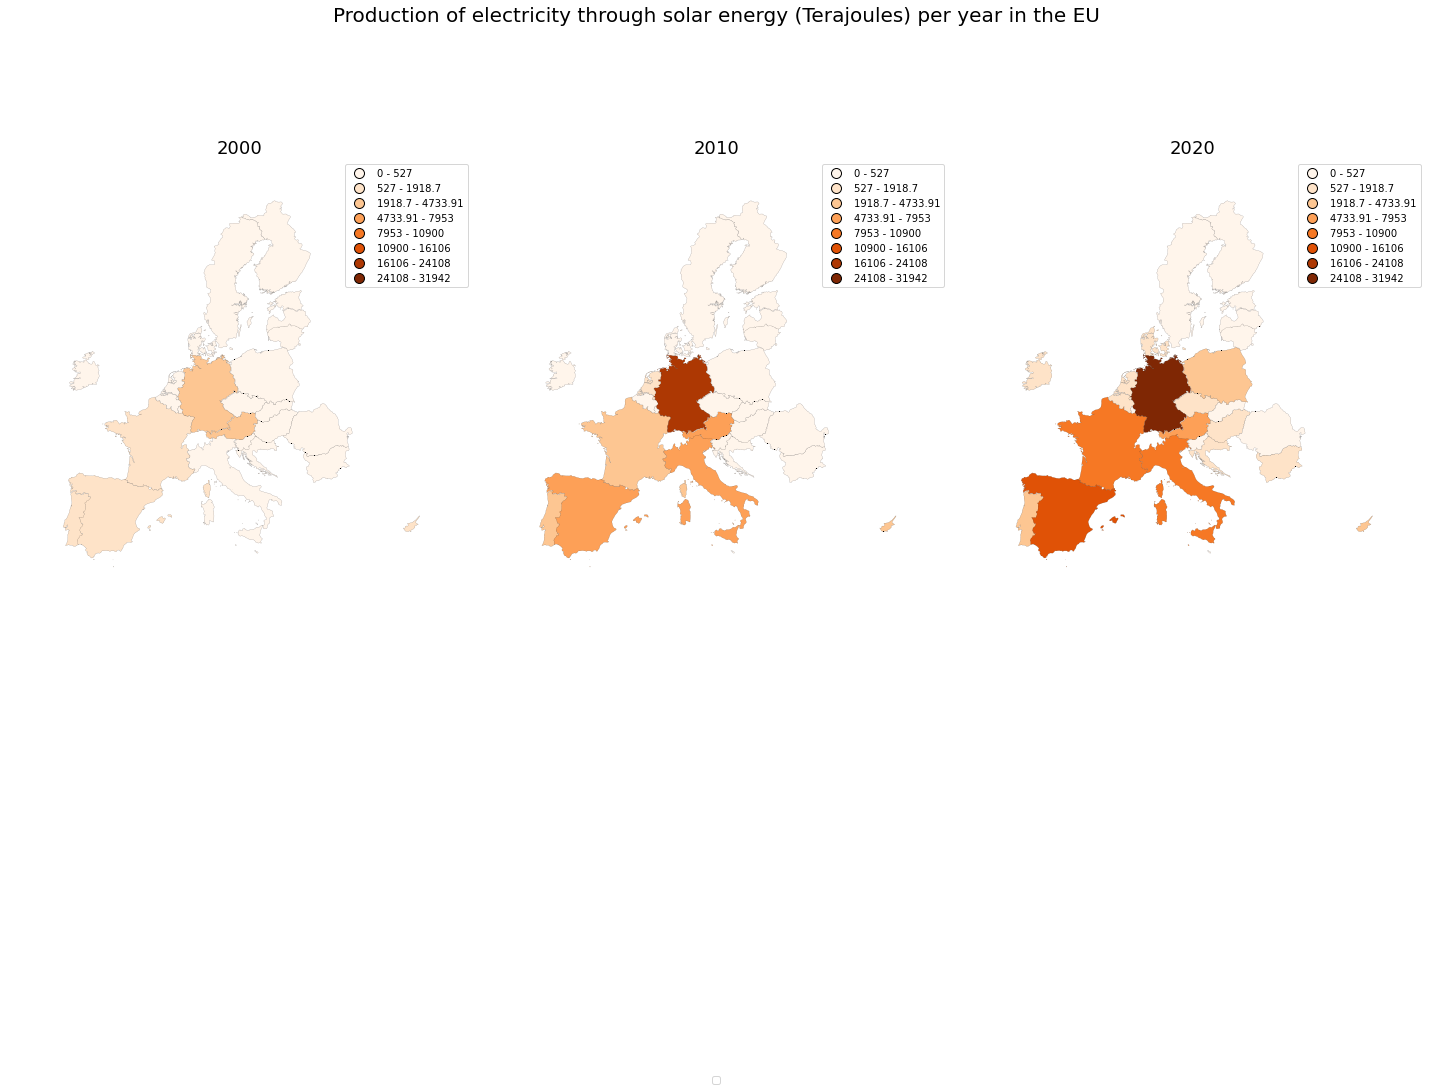

In [16]:
proj = gcrs.AlbersEqualArea() # We choose this projection so the countries are not squished and can be nicely seen

fig, axs = plt.subplots(1, 3, figsize = (20,20), subplot_kw={
    'projection': proj
})

df_input = merged_df.loc[merged_df['siec'] == "Solar thermal"] # We want to check solar energy

# set up the binning sheme
import mapclassify as mc
scheme = mc.NaturalBreaks(df_input['quantity'], k=8) # Bins are natural breaks (i.e. they best group similar values together 
                                                     # and maximize the differences between classes.)
data = df_input.copy()
# In case I need to change the limits
minx, miny, maxx, maxy = data.total_bounds

for i, yr in enumerate([2000, 2010, 2020]):
    
    data_subset = data.loc[(data["year"] == str(yr))]
    # Creating the choropleth map
    gplt.choropleth(data_subset, 
        hue='quantity', 
        linewidth=.1,
        scheme=scheme, cmap='Oranges',
        projection = proj,
        legend=True,
        edgecolor='black',
        ax=axs[i]
    )
    axs[i].set_title(f"{yr}", fontsize = 18)
    handles, labels = axs[i].get_legend_handles_labels()
    

plt.suptitle('Production of electricity through solar energy (Terajoules) per year in the EU', fontsize=20, y = 0.75)
fig.legend(handles, labels, loc='lower center')
plt.tight_layout()
plt.show()

From this chart we can see that the production of solar energy has increased from 2000 to 2020. The major producer is clearly Germany, followed by Spain and Italy. It could also be interesting to normalize this production for the number of inhabitants of each country, since now we have just an absolute value which is clearly related to the population of each country.

Since the above code is quite reusable, we can try to copy and paste it, just changing a couple of variables to visualize some energy sources of our choice. For example, let's visualize the evolution of geothermal and biogases power production from 2010 to 2020.

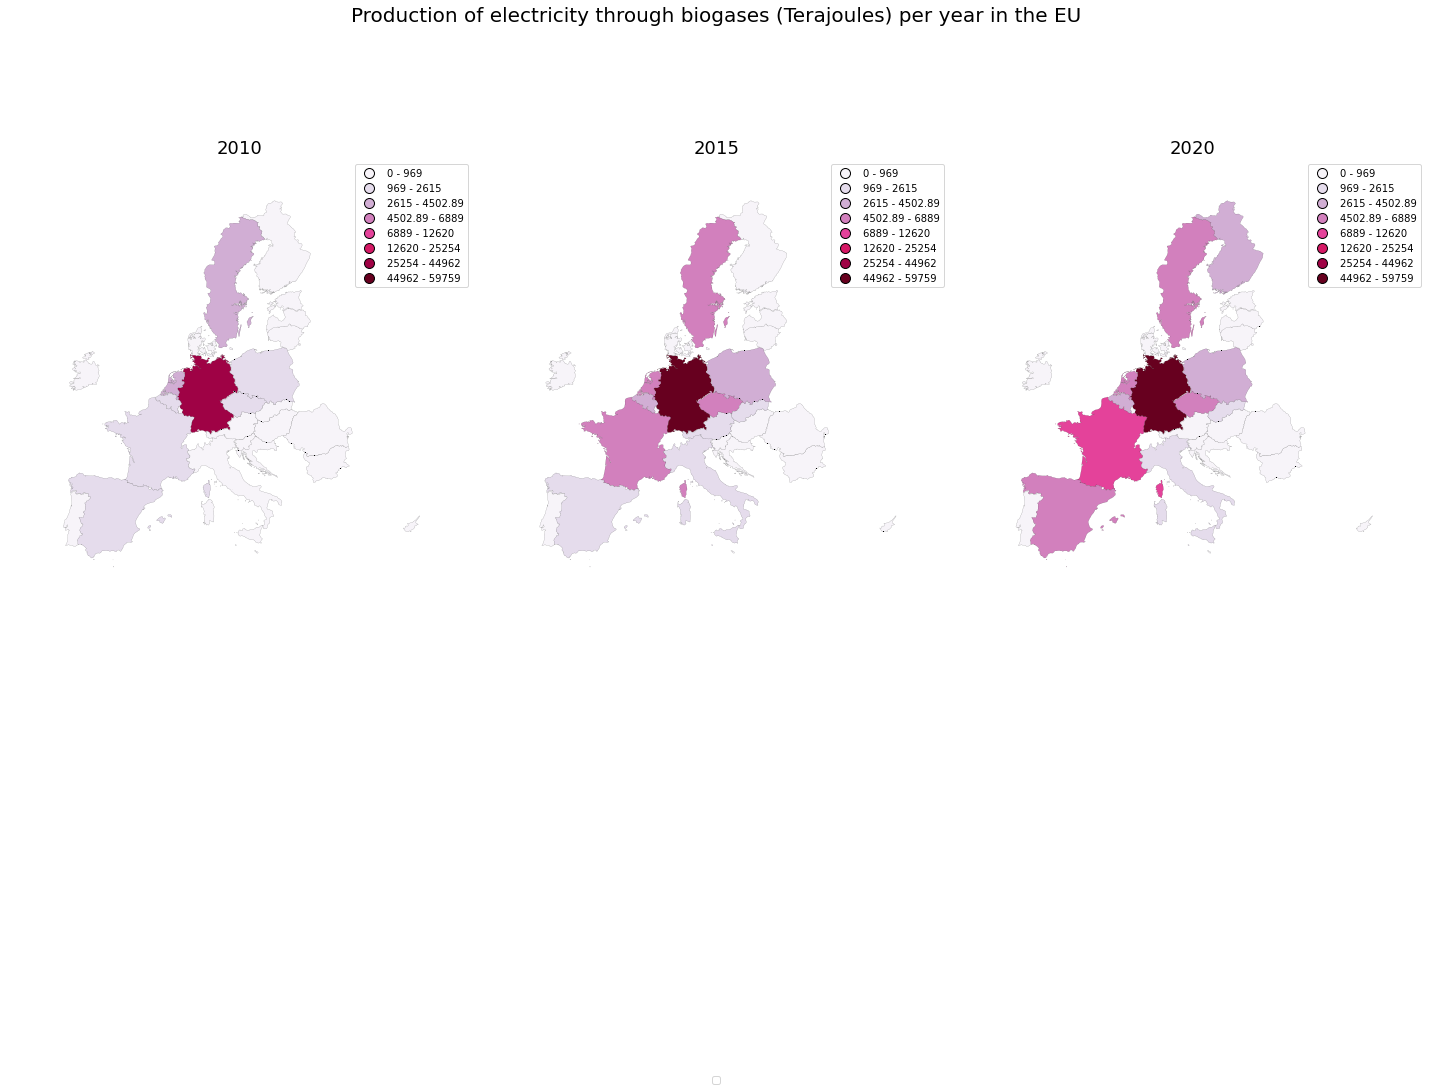

In [17]:
proj = gcrs.AlbersEqualArea()

fig, axs = plt.subplots(1, 3, figsize = (20,20), subplot_kw={
    'projection': proj
})

df_input = merged_df.loc[merged_df['siec'] == "Biogases"] # We want to check geothermal energy

# set up the binning sheme
import mapclassify as mc
scheme = mc.NaturalBreaks(df_input['quantity'], k=8)
data = df_input.copy()
# In case I need to change the limits
minx, miny, maxx, maxy = data.total_bounds

for i, yr in enumerate([2010, 2015, 2020]):
    
    data_subset = data.loc[(data["year"] == str(yr))]
    
    gplt.choropleth(data_subset, 
        hue='quantity', 
        linewidth=.1,
        scheme=scheme, cmap='PuRd',
        projection = proj,
        legend=True,
        edgecolor='black',
        ax=axs[i]
    )
    axs[i].set_title(f"{yr}", fontsize = 18)
    handles, labels = axs[i].get_legend_handles_labels()
    

plt.suptitle('Production of electricity through biogases (Terajoules) per year in the EU', fontsize=20, y = 0.75)
fig.legend(handles, labels, loc='lower center')
plt.tight_layout()
plt.show()

Here we see that again, Germany is the largest producer of energy from biogases in the EU, followed by France.

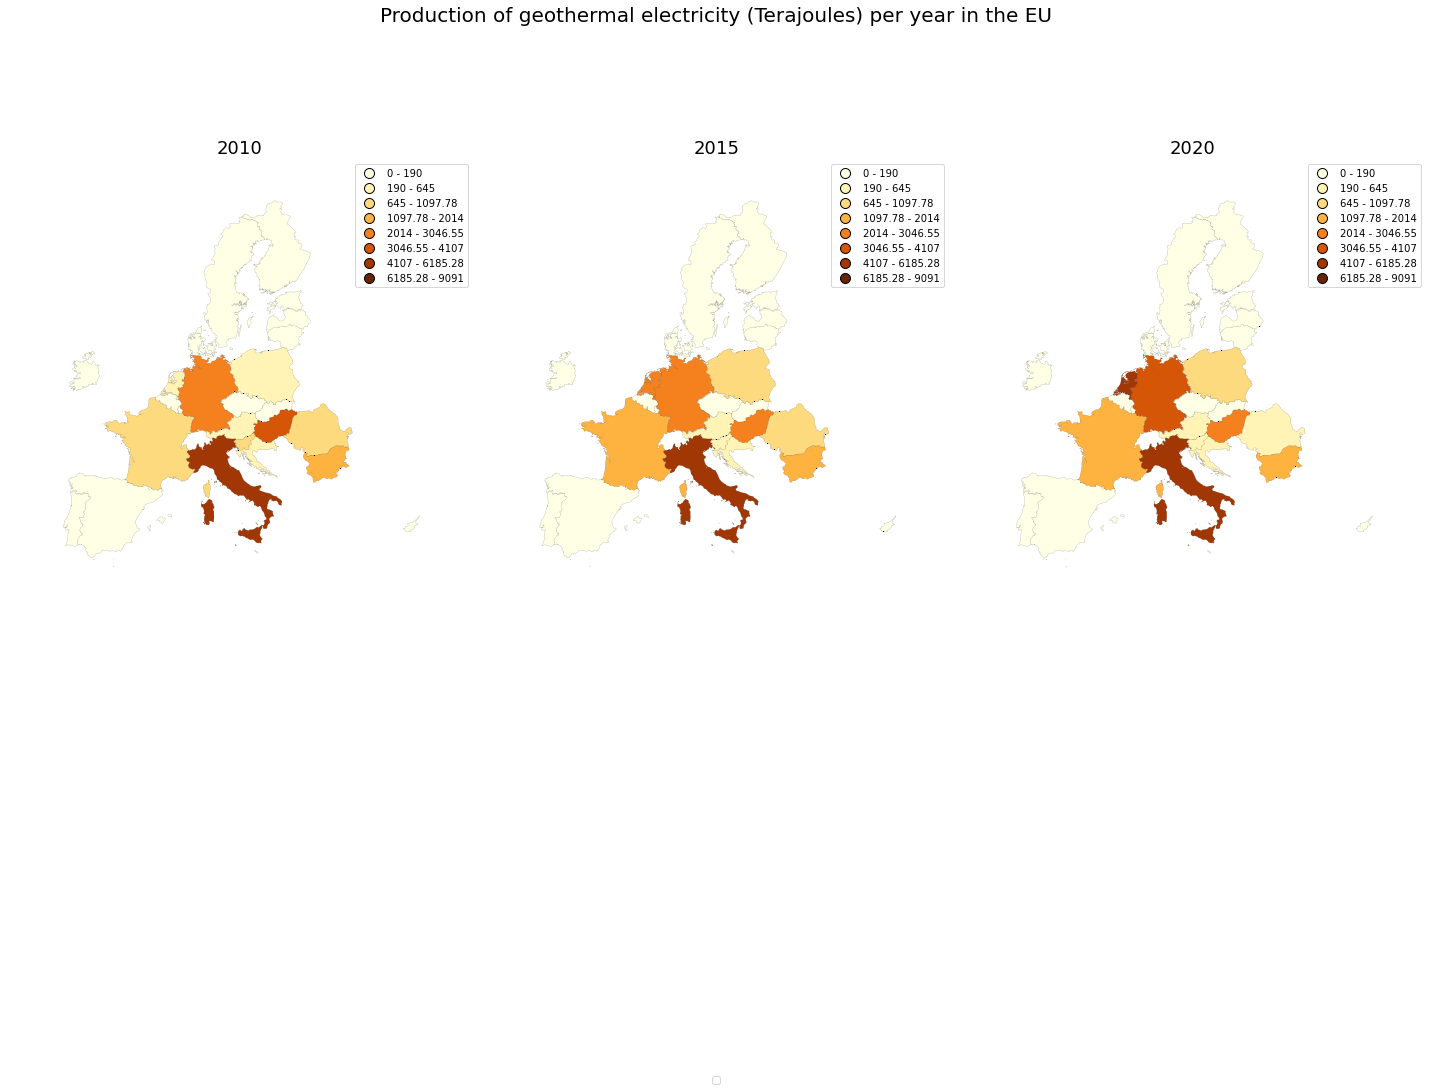

In [18]:
proj = gcrs.AlbersEqualArea()

fig, axs = plt.subplots(1, 3, figsize = (20,20), subplot_kw={
    'projection': proj
})

df_input = merged_df.loc[merged_df['siec'] == "Geothermal"] # We want to check geothermal energy

# set up the binning sheme
import mapclassify as mc
scheme = mc.NaturalBreaks(df_input['quantity'], k=8)
data = df_input.copy()
# In case I need to change the limits
minx, miny, maxx, maxy = data.total_bounds

for i, yr in enumerate([2010, 2015, 2020]):
    
    data_subset = data.loc[(data["year"] == str(yr))]
    
    gplt.choropleth(data_subset, 
        hue='quantity', 
        linewidth=.1,
        scheme=scheme, cmap='YlOrBr',
        projection = proj,
        legend=True,
        edgecolor='black',
        ax=axs[i]
    )
    axs[i].set_title(f"{yr}", fontsize = 18)
    handles, labels = axs[i].get_legend_handles_labels()
    

plt.suptitle('Production of geothermal electricity (Terajoules) per year in the EU', fontsize=20, y = 0.75)
fig.legend(handles, labels, loc='lower center')
plt.tight_layout()
plt.show()

Italy seems to be the lead producer of geothermal energy in Europe in 2020, quickly followed by the Netherlands. Actually, since they have the same color on the choropleth map, we do not know which of the two countries has the highest value!
To solve this problem, we could use a simple barplot.

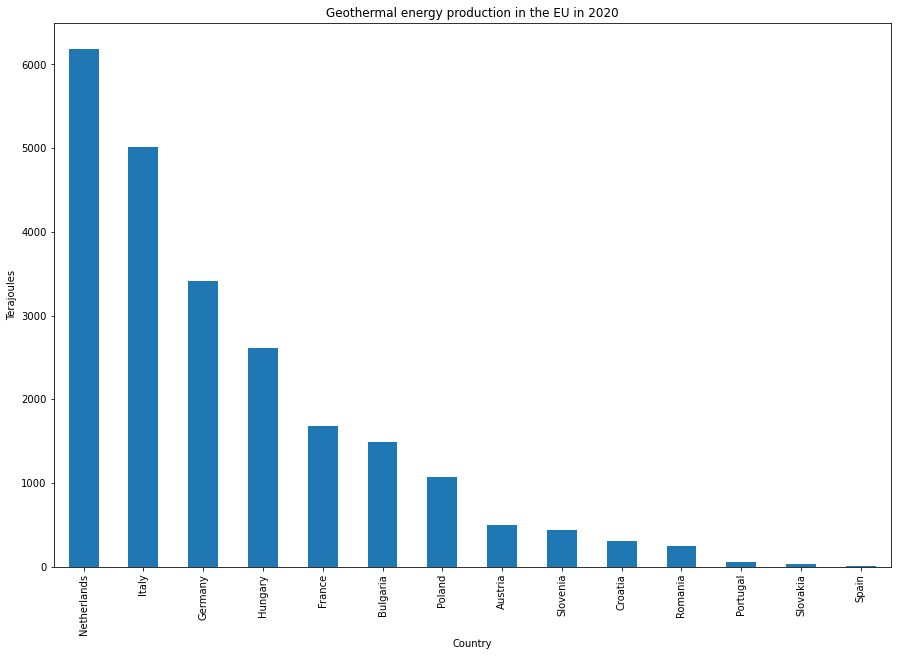

In [19]:
data_subset_geo2020 = data_subset.copy()
# We removing countries which do not use geothermal energy for heating, so that the barplot is less cluttered
data_subset_geo2020 = data_subset_geo2020[data_subset_geo2020["quantity"] > 0] 

data_subset_geo2020.sort_values("quantity", ascending=False).plot.bar("NAME", "quantity", figsize = (15, 10), legend = False)

plt.title("Geothermal energy production in the EU in 2020")
plt.xlabel("Country")
plt.ylabel("Terajoules")

plt.show()

It is quite surprising to notice that the Netherlands are the country with the highest geothermal production for energy use in the EU!

## Diving deeper: visualizing renewable energy mixes

One interesting thing to know would be to compare renewable energy mixes among different countries. We can visualize those using waffle charts, or simple bar charts. In my opinion, it is better to avoid using pie charts, as they are not very effective at communicating data in a precise way. As a matter of fact, we humans are not very good at estimating quantities from areas (or angles). Moreover, in case of small percentages, it is very difficult to distinguish them correctly.

So, let's go back to our df_eu and select all the rows which refer to Italy in 2020 (the latest available year).
We then create a new column with percentages instead of absolute values (this is useful to compare different countries).

In [20]:
df_italy = df_eu[(df_eu["country_code"] == "IT") & (df_eu["year"] == "2020")]
df_italy['quantity_percent'] = (df_italy['quantity']/df_italy['quantity'].sum())*100

df_france = df_eu[(df_eu["country_code"] == "FR") & (df_eu["year"] == "2020")]
df_france['quantity_percent'] = (df_france['quantity']/df_france['quantity'].sum())*100

df_spain = df_eu[(df_eu["country_code"] == "ES") & (df_eu["year"] == "2020")]
df_spain['quantity_percent'] = (df_spain['quantity']/df_spain['quantity'].sum())*100

df_germany = df_eu[(df_eu["country_code"] == "DE") & (df_eu["year"] == "2020")]
df_germany['quantity_percent'] = (df_germany['quantity']/df_germany['quantity'].sum())*100

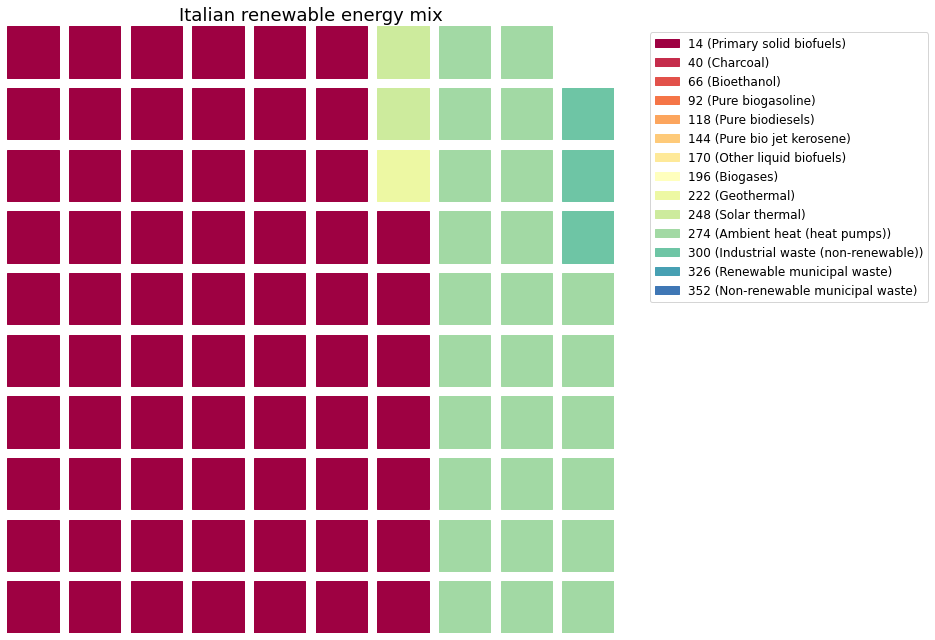

In [21]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

# Prepare the dataset
n_categories = df_italy.shape[0]
colors = [plt.cm.Spectral(i / float(n_categories)) for i in range(n_categories)]

# Draw Plot and Decorate
fig = plt.figure(
    FigureClass=Waffle,
    rows=10, # how many rows we want it to have
    values=df_italy["quantity_percent"],
    labels=[
        "{0} ({1})".format(n[0], n[1]) for n in df_italy[["siec", "quantity_percent"]].itertuples()
    ],
    legend={"loc": "upper left", "bbox_to_anchor": (1.05, 1), "fontsize": 12},
    title={"label": "Italian renewable energy mix", "loc": "center", "fontsize": 18},
    colors=colors,
    figsize=(16, 9),
)

We have a 10x10 waffle chart, each cell corresponding to 1% of the total renewable energy production in 2020. Notice how we actually have 99 cells: this is due to the percentages rounding.

It seems that about 2/3 of italian renewable energy production come from "primary solid biofuels". According to [this reference](), this voice represents "a product aggregate equal to the sum of fuelwood, wood residues and by-products, black liquor, bagasse, animal waste, other vegetal materials and residuals and renewable fraction of industrial waste." It would surely be interesting to break down this aggregate into its components and see the contribution of each one of them. 

Another 26% is given by ambient heat, 3% comes from industrial waste, 2% from solar thermal and 1% from geothermal. The other sources account for either extremely tiny or null values.

Let us now compare the Italian renewable energy mix with those of France, Germany and Spain.


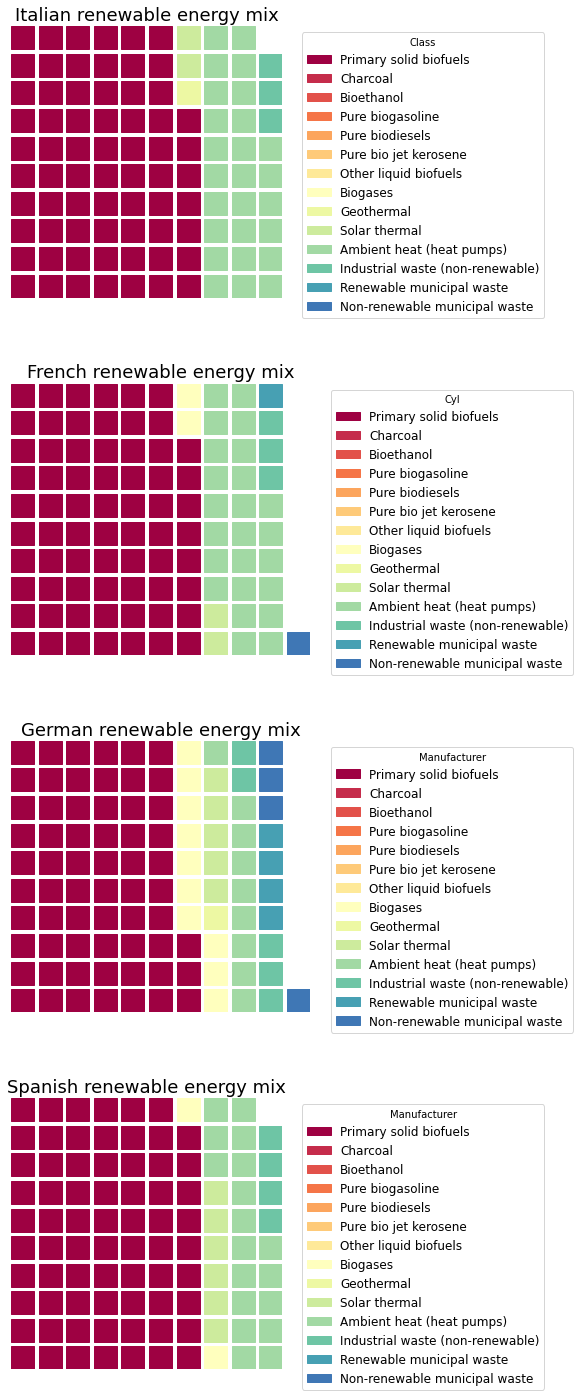

In [22]:
fig = plt.figure(
    FigureClass=Waffle,
    plots={ # all the options as a dictionary called plots
        411: {
            'values': df_italy['quantity_percent'],
            'labels': ["{1}".format(n[0], n[1]) for n in df_italy[['siec', 'quantity_percent']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Energy source'},
            'title': {'label': 'Italian renewable energy mix', 'loc': 'center', 'fontsize':18},
            'colors': colors
        },
        412: {
            'values': df_france['quantity_percent'],
            'labels': ["{1}".format(n[0], n[1]) for n in df_france[['siec', 'quantity_percent']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Energy source'},
            'title': {'label': 'French renewable energy mix', 'loc': 'center', 'fontsize':18},
            'colors': colors
        },
        413: {
            'values': df_germany['quantity_percent'],
            'labels': ["{1}".format(n[0], n[1]) for n in df_germany[['siec', 'quantity_percent']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Energy source'},
            'title': {'label': 'German renewable energy mix', 'loc': 'center', 'fontsize':18},
            'colors': colors
        },
        414: {
            'values': df_spain['quantity_percent'],
            'labels': ["{1}".format(n[0], n[1]) for n in df_spain[['siec', 'quantity_percent']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Energy source'},
            'title': {'label': 'Spanish renewable energy mix', 'loc': 'center', 'fontsize':18},
            'colors': colors
        }
    },
    rows=10,
    figsize=(20, 20)
)

It seems that for all of these four countries, primary solid biofuels accounts for 60-70% percent of the total renewable energy production. Also, ambient heat is the second energy sources for all of them, except for Germany where it is the third (9%), just after biogases (10%).

Spain has the highest share of solar thermal energy (6% of its total), whereas Germany has a fair share of municipal waste (8%), equally shared between renewable and non-renewable.

French energy mix is really similar to the italian one, except for the presence of a more relevant biogases production (2% against 0 production in Italy) and some municipal waste (2%), and the absence of geothermal energy. 

Again, notice how, due to the rounding of the percentage column, some countries have 99 or 101 tiles.

In [23]:
df_france

,nrg_bal,siec,unit,country_code,year,quantity,quantity_percent
10,FC_E,Primary solid biofuels,TJ,FR,2020,322709.587,67.563183
36,FC_E,Charcoal,THS_T,FR,2020,0.000,0.000000
62,FC_E,Bioethanol,THS_T,FR,2020,0.000,0.000000
88,FC_E,Pure biogasoline,THS_T,FR,2020,0.000,0.000000
114,FC_E,Pure biodiesels,THS_T,FR,2020,0.000,0.000000
140,FC_E,Pure bio jet kerosene,THS_T,FR,2020,0.000,0.000000
166,FC_E,Other liquid biofuels,THS_T,FR,2020,26.775,0.005606
192,FC_E,Biogases,TJ,FR,2020,10452.160,2.188287
218,FC_E,Geothermal,TJ,FR,2020,1681.294,0.351999
244,FC_E,Solar thermal,TJ,FR,2020,8145.420,1.705343


## Visualizing evolution over time

Earlier we had a glimpse of the evolution of some kinds of energy production over time. However, we would like to have an idea of what happened year-by-year. We can use a classic line chart in this case. 

For example, let's visualize the production of solar thermal energy in the four most popolous EU countries (*i.e.* Germany, France, Italy, Spain) from 1990 to 2020. We are going to use the library **seaborn**, which makes it very easy to produce nice looking plots with minimal code.


In [24]:
df_eu4 = df_eu.loc[df_eu['country_code'].isin(["IT","FR","ES","DE"])]
df_eu4.year = pd.to_numeric(df_eu4.year, errors='coerce') # convert year from string to integer
df_eu4_solar = df_eu4[df_eu4["siec"] == "Solar thermal"]

df_eu4_solar


,nrg_bal,siec,unit,country_code,year,quantity
239,FC_E,Solar thermal,TJ,DE,2020,31332.000
242,FC_E,Solar thermal,TJ,ES,2020,13715.766
244,FC_E,Solar thermal,TJ,FR,2020,8145.420
248,FC_E,Solar thermal,TJ,IT,2020,9887.193
603,FC_E,Solar thermal,TJ,DE,2019,30525.000
...,...,...,...,...,...,...
10804,FC_E,Solar thermal,TJ,IT,1991,229.000
11159,FC_E,Solar thermal,TJ,DE,1990,468.000
11162,FC_E,Solar thermal,TJ,ES,1990,847.165
11164,FC_E,Solar thermal,TJ,FR,1990,1015.000


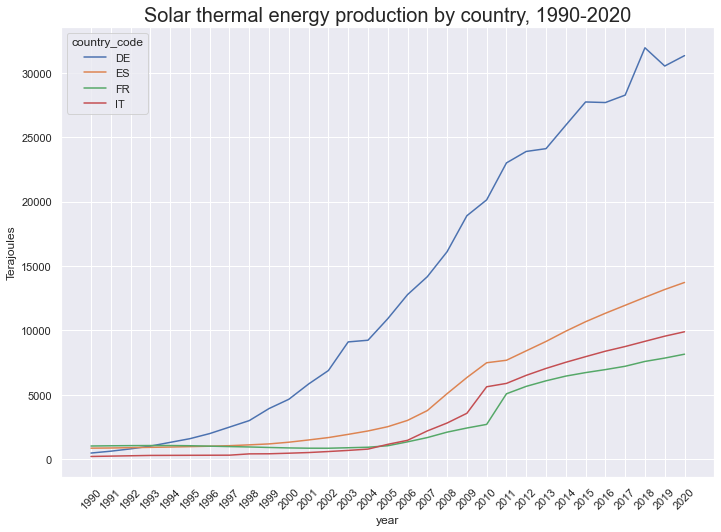

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

my_plot = sns.lineplot(data = df_eu4_solar, x = "year", y= "quantity", hue = "country_code")

plt.xticks(rotation=45)
my_plot.set_xticks(range(1990,2021))
my_plot.set_ylabel("Terajoules")

plt.title("Solar thermal energy production by country, 1990-2020", size = 20)
plt.show()

It's possible to see how the four countries started roughly at the same point in 1990, but evolved in different ways. In particular, Germany takes the lion's share, surpassing the other countries in 1994 and developing its production at a much larger pace than the other three countries. In fact, its solar thermal energy production in 2020 (31332 TJ) is more than double the Spanish (13716 TJ), the triple of the Italian (9887 TJ) and almost four times the French one (8145 TJ).

France, Italy and Spain have started increasing their production much later. A substantial increase can be seen to start from 2005 for Italy and France, while Spain had started to increase its production around 1998. Around 2009-2010 there seem to have been a boost in such kind of energy production, and from that moment onwards growth has been steady for those three countries. However, their growth rate is much smaller than that of Germany. 


Let us now do the same with biogases.

In [26]:
df_eu4_biogas = df_eu4[df_eu4["siec"] == "Biogases"]

df_eu4_biogas

,nrg_bal,siec,unit,country_code,year,quantity
187,FC_E,Biogases,TJ,DE,2020,59759.000
190,FC_E,Biogases,TJ,ES,2020,5074.000
192,FC_E,Biogases,TJ,FR,2020,10452.160
196,FC_E,Biogases,TJ,IT,2020,1523.231
551,FC_E,Biogases,TJ,DE,2019,58200.000
...,...,...,...,...,...,...
10752,FC_E,Biogases,TJ,IT,1991,0.000
11107,FC_E,Biogases,TJ,DE,1990,5871.000
11110,FC_E,Biogases,TJ,ES,1990,425.000
11112,FC_E,Biogases,TJ,FR,1990,2323.000


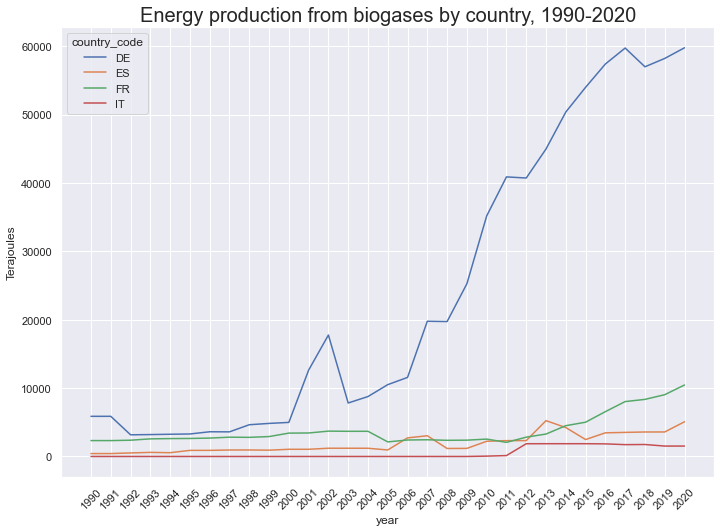

In [27]:
my_plot = sns.lineplot(data = df_eu4_biogas, x = "year", y= "quantity", hue = "country_code")

plt.xticks(rotation=45)
my_plot.set_xticks(range(1990,2021))
my_plot.set_ylabel("Terajoules")

plt.title("Energy production from biogases by country, 1990-2020", size = 20)
plt.show()

Once again, we notice how Germany has a much different trend compared to Italy, France and Spain. In particular, Germany started in 1990 already producing much more biogases than the other three countries. Production stayed almost stable until 2000, where it sharply arose to about 18000 TJ in 2002, before declining the following year to half of this value. From then onwards, production of biogases rose sharply, except for a couple of exceptional years in 2007-2008 and 2011-2012. In 2020, Germany biogases production was 59759 TJ, almost six times the second largest producer of this type of energy in the EU, *i.e.* France, with 10452 TJ produced in the same year.

French biogases production remained basically stable until 2012, where it started do slowly increasing until 2020. The spanish trend is comparable to this, although reaching a much lower value of 5074 TJ produced in 2020. 
Italy has produced almost zero energy from biogases until 2012. From then onwards, production have been on a slight decline, accounting for 1523 TJ in 2020.



This was just a brief example of the Data Science workflow. We started from a "dirty" dataset, we cleaned it and prepared for our analysis and visualization. We used different types of graphs which shed light on some aspects of the dataset which might not have been obvious by just looking at the numbers.
